# 数据预处理
将图片缩放到 1024 * 768

In [1]:
from pathlib import Path
test_img_path = Path('./datasets/')
clothes_img_list = [str(i) for i in list(test_img_path.rglob('test/cloth/*.jpg'))]
person_img_list = [str(i) for i in list(test_img_path.rglob('test/image/*.jpg'))]
clothes_edge_img_list = [str(i) for i in list(test_img_path.rglob('test/cloth-mask/*.jpg'))]
print("clothes_img_list:", clothes_img_list)
print("person_img_list:", person_img_list)
print("clothes_edge_img_list:", clothes_edge_img_list)

clothes_img_list: ['datasets/test/cloth/00001.jpg']
person_img_list: ['datasets/test/image/10549_00.jpg', 'datasets/test/image/m_00001.jpg', 'datasets/test/image/m_00002.jpg']
clothes_edge_img_list: ['datasets/test/cloth-mask/00001.jpg']


In [2]:
import cv2
for p in person_img_list:
    print(p)
    p_img = cv2.imread(p)
    print(p_img.shape)
    # 注意 opencv resize 的 size 是: (w, h)
    p_img = cv2.resize(p_img, (768, 1024), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(p, p_img)

datasets/test/image/10549_00.jpg
(1024, 768, 3)
datasets/test/image/m_00001.jpg
(1024, 768, 3)
datasets/test/image/m_00002.jpg
(1024, 768, 3)


# 浏览测试数据(Input Data)

In [13]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

def show_imgs(imgs, horizon=True, h=24, w=12):
    plt.figure(figsize=(h, w), dpi=100)
    for i, img in enumerate(imgs):
        if horizon:
            sub_plt = plt.subplot(1, len(imgs), i+1)
        else:
            sub_plt = plt.subplot(len(imgs), 1, i+1)
        _, img_name = img.rsplit('/', 1)
        img = cv2.imread(img)
        sub_plt.imshow(img[:,:,::-1])
        sub_plt.set_title(img_name)

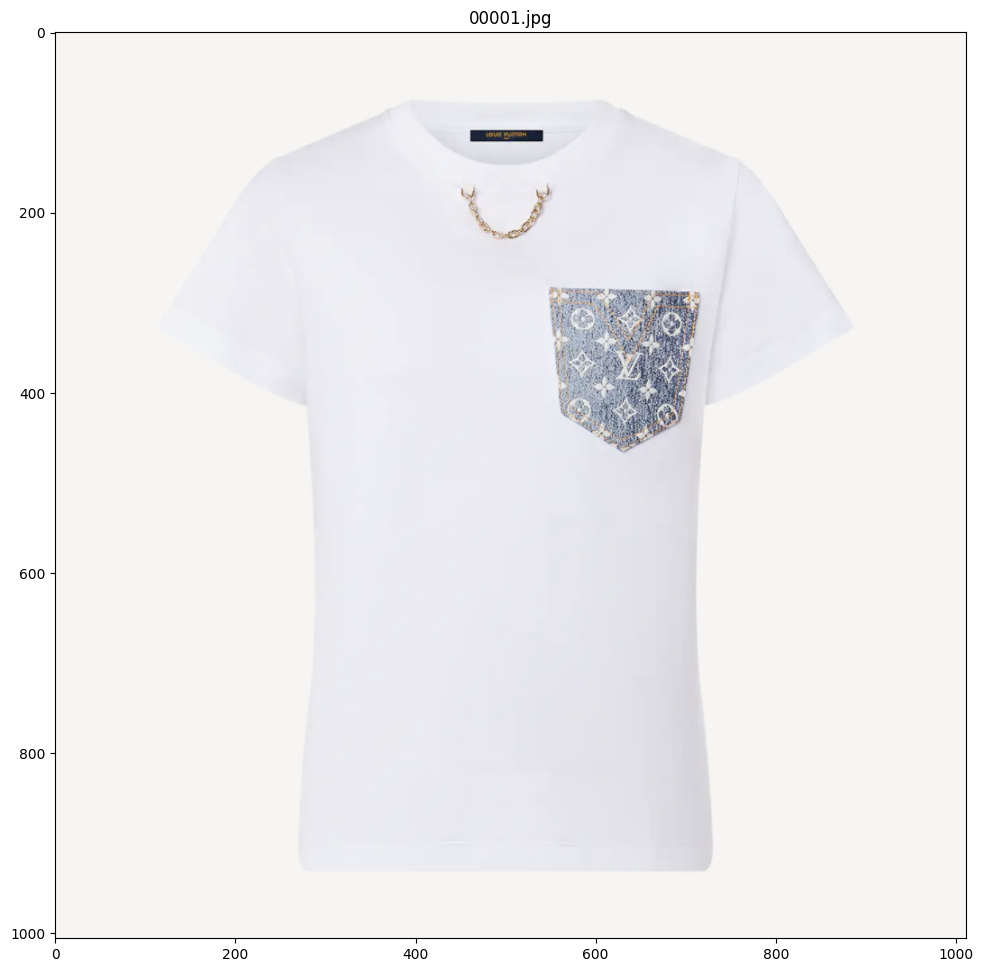

In [14]:
# Garment
show_imgs(clothes_img_list)

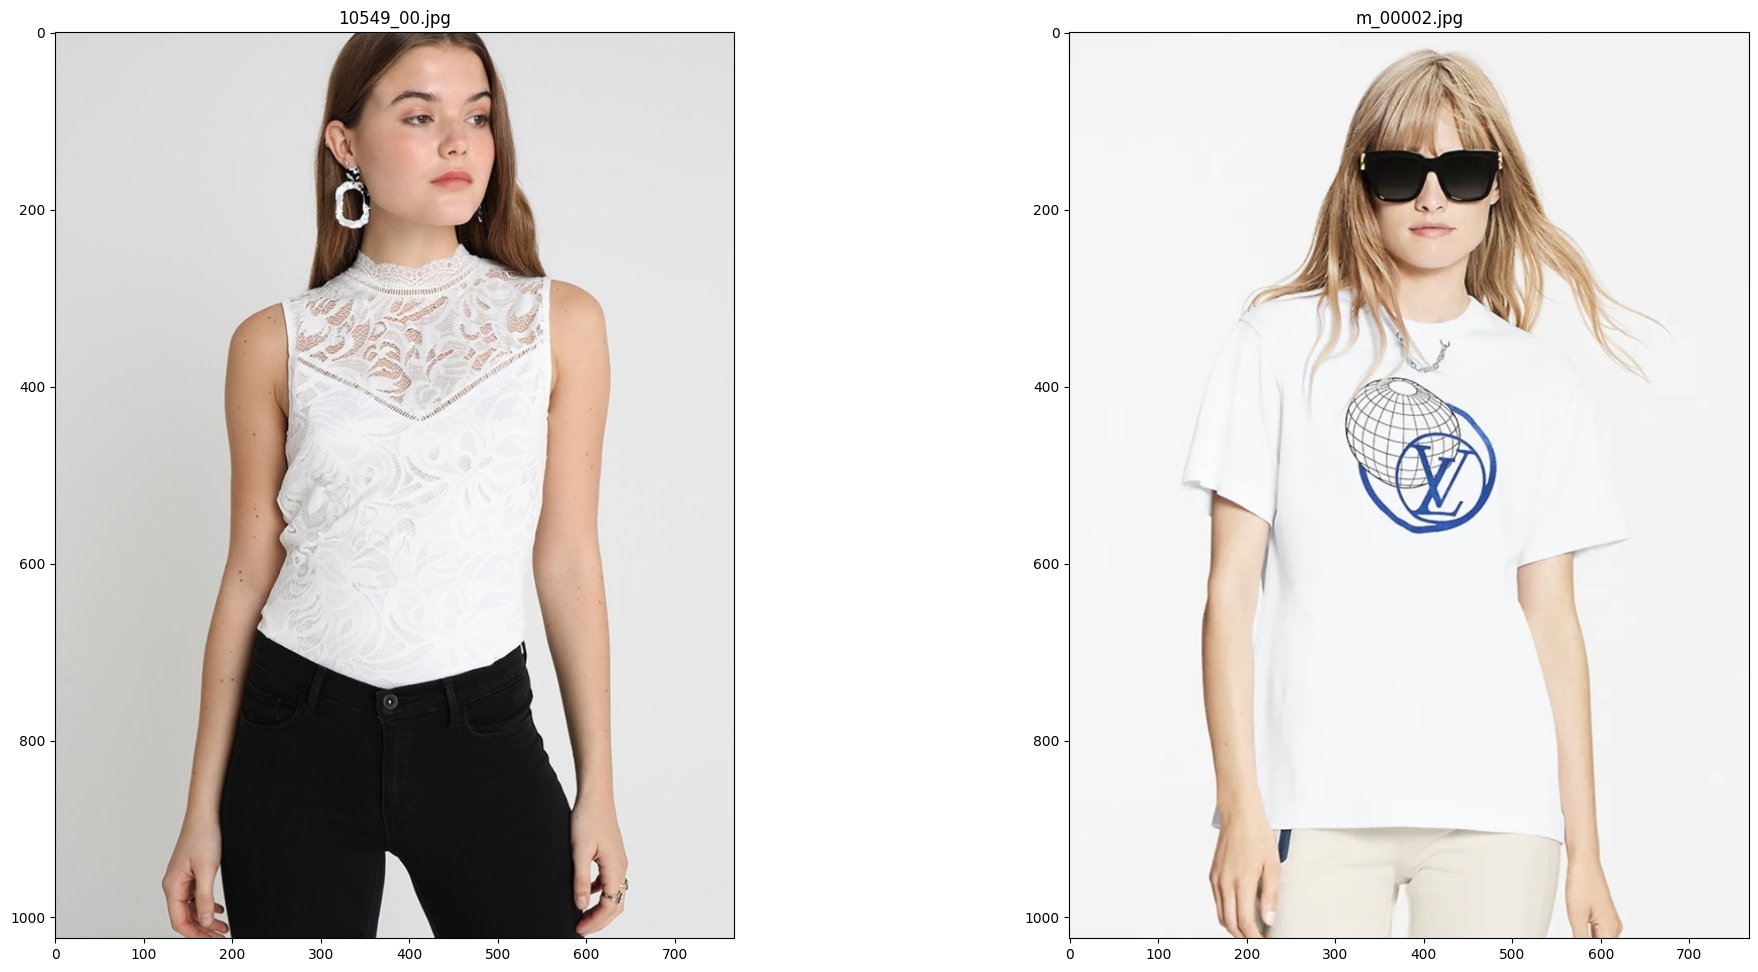

In [15]:
# Person
show_imgs(person_img_list)

# Virtual Try-On

In [16]:
!rm -rf ./results/
!python test.py --name demo

Namespace(alias_checkpoint='alias_final.pth', batch_size=1, checkpoint_dir='./checkpoints/', dataset_dir='./datasets/', dataset_list='test_pairs.txt', dataset_mode='test', display_freq=1, gmm_checkpoint='gmm_final.pth', grid_size=5, init_type='xavier', init_variance=0.02, load_height=1024, load_width=768, name='demo', ngf=64, norm_G='spectralaliasinstance', num_upsampling_layers='most', save_dir='./results/', seg_checkpoint='seg_final.pth', semantic_nc=13, shuffle=False, workers=1)
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
/root/miniconda3/envs/jia/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type In

# result

In [17]:
result_img_path = Path('./results/')
res_imgs = [ str(i) for i in result_img_path.rglob('demo/*.jpg')]
print(res_imgs)

['results/demo/m_00001.jpg', 'results/demo/10549_00001.jpg']


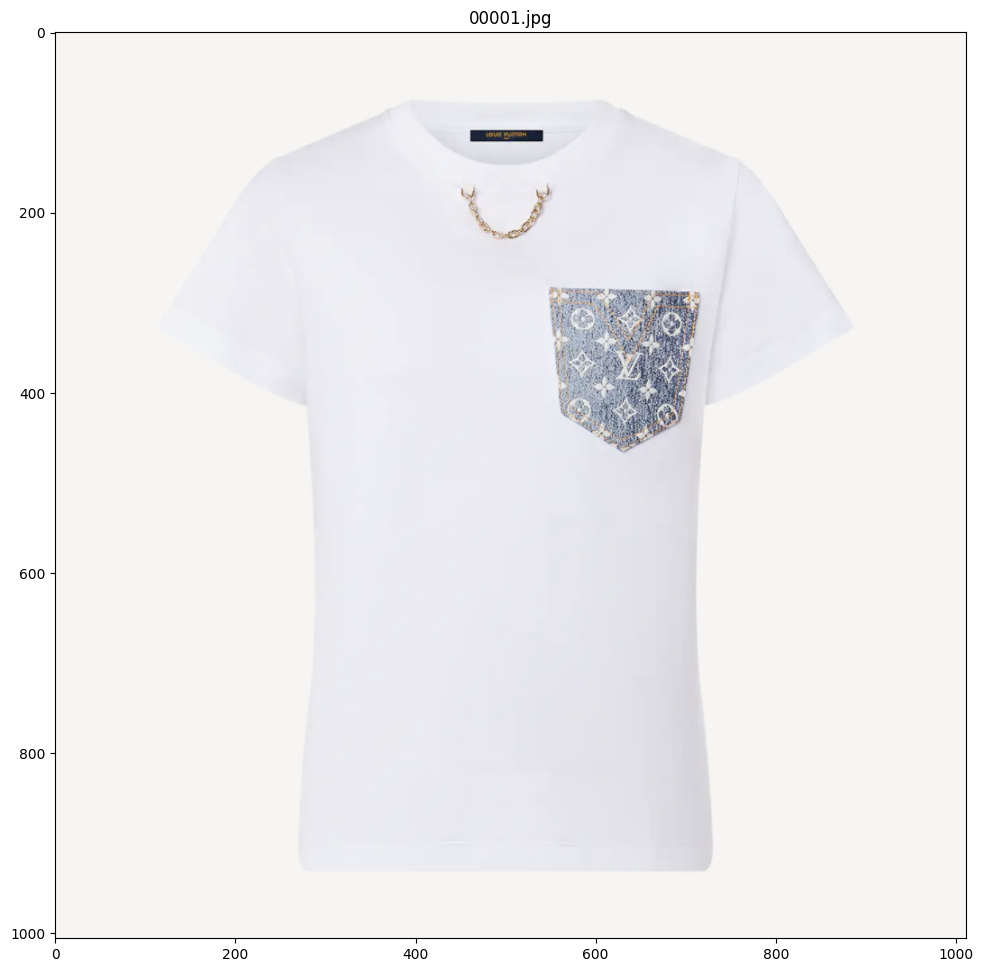

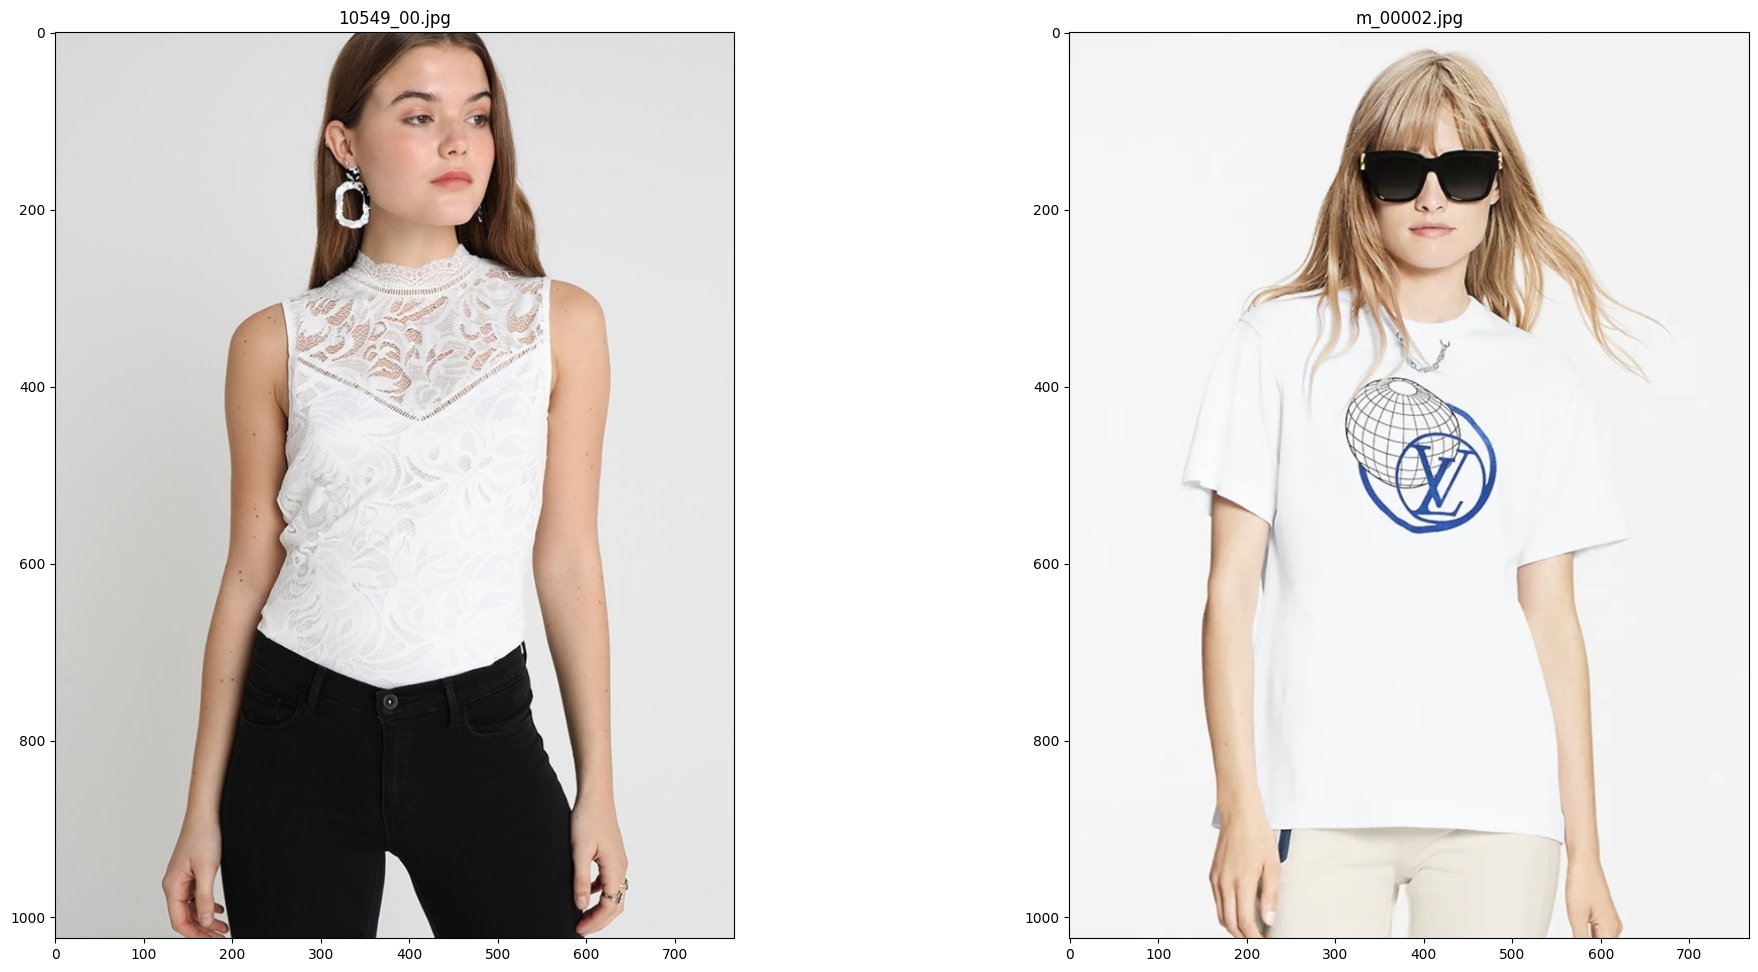

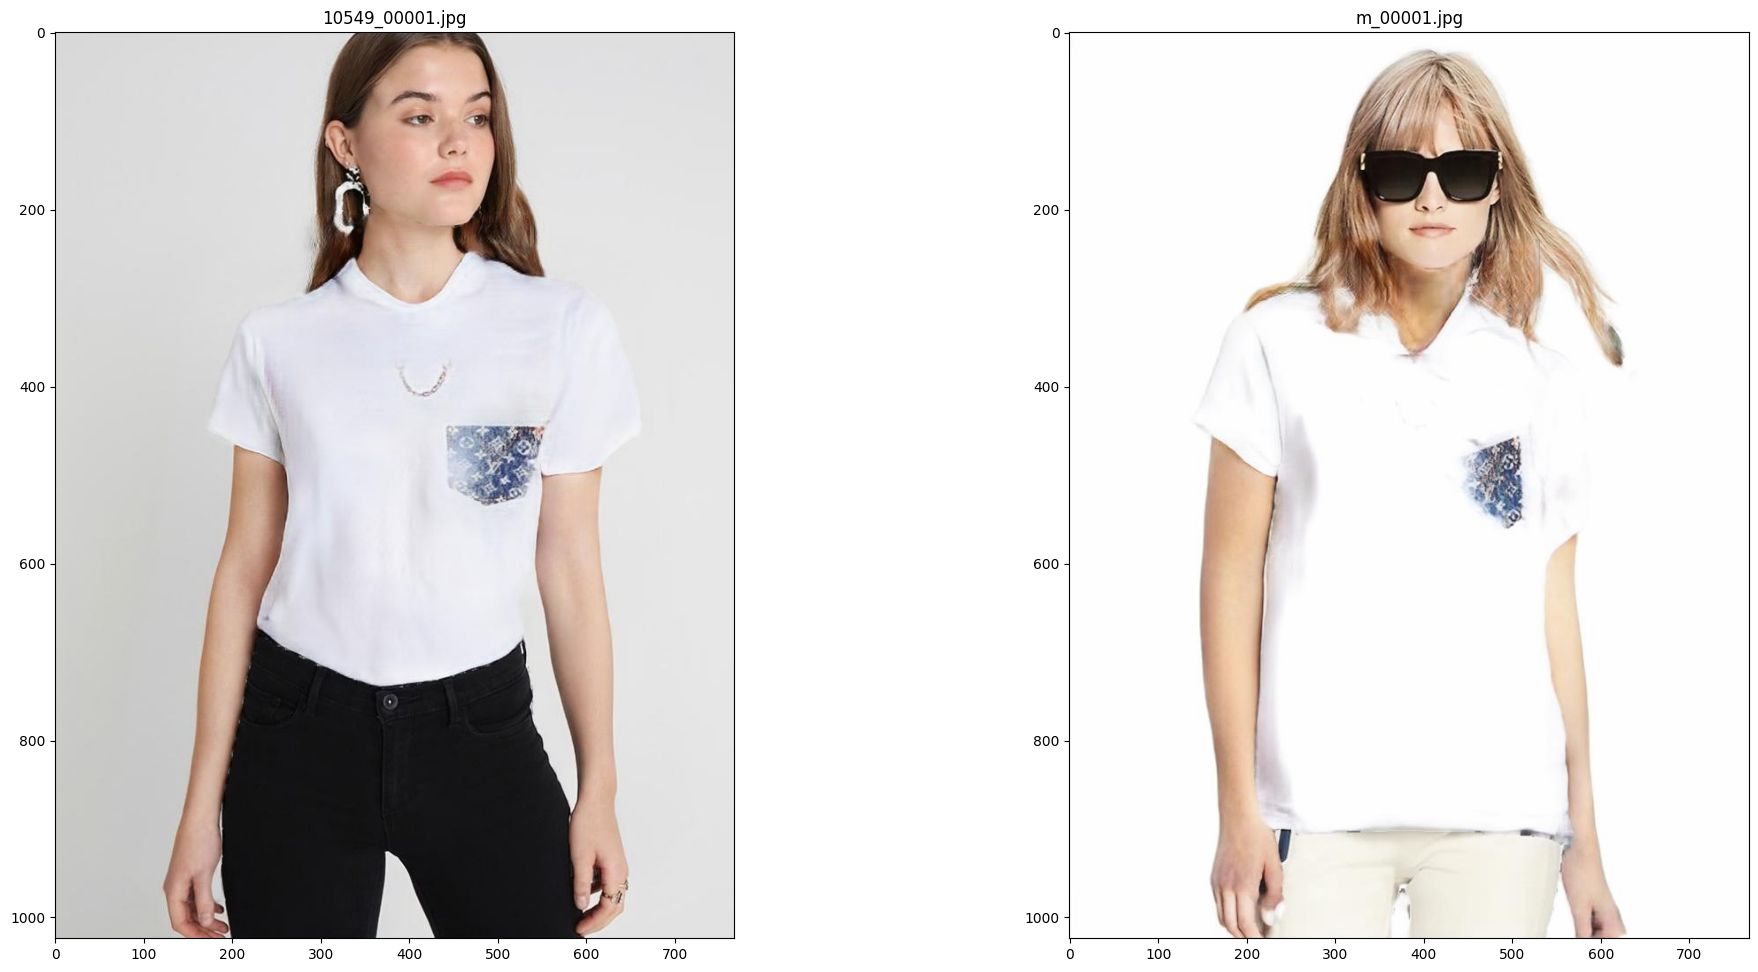

In [18]:
show_imgs(sorted(clothes_img_list))
show_imgs(sorted(person_img_list))
show_imgs(sorted(res_imgs))